In [1]:
# Third Party Library Imports
import pandas as pd
import numpy as np
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
import io
import glob

In [2]:
#printing the versions of libraries
print('Pandas: {:s}'.format(pd.__version__))
print('Numpy: {:s}'.format(np.__version__))
print('Scikit Learn Version:', sklearn.__version__)

Pandas: 1.3.5
Numpy: 1.21.6
Scikit Learn Version: 1.0.2


In [3]:
# Loading all the 7 different malicious datasets into respective dataframes

gagfyt_df = pd.read_csv('../input/malware-iot-log-file/Gagfyt.csv')
Hide_and_seek_df = pd.read_csv('../input/malware-iot-log-file/Hide_and_seek.csv')
Kenjiro_df = pd.read_csv('../input/malware-iot-log-file/Kenjiro.csv')
Linux_Hajime_df = pd.read_csv('../input/malware-iot-log-file/Linux_Hajime_df.csv')
Mirai_df = pd.read_csv('../input/malware-iot-log-file/Mirai.csv')
Muhstik_df = pd.read_csv('../input/malware-iot-log-file/Muhstik.csv')
Okiru_df = pd.read_csv('../input/malware-iot-log-file/Okiru.csv')                           

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Cleannig malware sub-set dataframes

In [4]:
# List of dataframes to be concatenated
pdList = [gagfyt_df, Hide_and_seek_df, Kenjiro_df, Mirai_df, Muhstik_df,Okiru_df, Linux_Hajime_df]  
df = pd.concat(pdList,ignore_index=True)

In [5]:
# concatinating the column Traffic labeled with malicous type and if it's benign just keeping the values as benign
df['Traffic_Labeled'] = np.where(df['Traffic_Labeled']!="Benign", df['Traffic_Labeled'] + df['Malware'], df['Traffic_Labeled'])

# dropping the unecessaty columns
df.drop(["tunnel_parents   label   detailed-label", "Tunnel", "Malware","index"], axis =1, inplace = True)

In [6]:
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,Traffic_Labeled
0,2019-09-20 22:27:19.984081920,CjnBrQ3lWRLcSTnJV6,192.168.1.195,4512,162.248.88.215,62336,tcp,NaN,NaN,NaN,...,OTH,NaN,NaN,0,C,0,0,0,0,Malicious DDoS
1,2019-09-20 22:25:46.017224960,CHL0ex2ROJt8hD3up6,192.168.1.195,49327,162.248.88.215,62336,tcp,NaN,NaN,NaN,...,OTH,NaN,NaN,0,C,0,0,0,0,Malicious DDoS
2,2019-09-20 22:25:34.246748928,C7bfRx4kiGSypeozCd,162.248.88.215,62336,192.168.1.195,614,tcp,NaN,NaN,NaN,...,OTH,NaN,NaN,0,^c,0,0,0,0,Benign
3,2019-09-20 22:26:06.340357120,CE7K0r1ua7NTzBHGDf,192.168.1.195,29776,162.248.88.215,62336,tcp,NaN,NaN,NaN,...,OTH,NaN,NaN,0,C,0,0,0,0,Malicious DDoS
4,2019-09-20 22:23:52.564219904,CylM264HX2dYzLJAl6,162.248.88.215,62336,192.168.1.195,3389,tcp,NaN,NaN,NaN,...,OTH,NaN,NaN,0,^c,0,0,0,0,Benign


# Data Pre Processing

In [7]:
# removing the white spaces before and after the string
df['Traffic_Labeled'] = df['Traffic_Labeled'].str.strip()

In [8]:
df['Traffic_Labeled'].value_counts()

Benign                                 1885954
Malicious PartOfAHorizontalPortScan    1526588
Malicious Okiru                         356530
Malicious DDoS                            2476
Malicious Attack                           199
Malicious C&C-HeartBeat                    154
Malicious C&C                                7
Name: Traffic_Labeled, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3771908 entries, 0 to 3771907
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ts               object 
 1   uid              object 
 2   id.orig_h        object 
 3   id.orig_p        int64  
 4   id.resp_h        object 
 5   id.resp_p        int64  
 6   proto            object 
 7   service          object 
 8   duration         object 
 9   orig_bytes       float64
 10  resp_bytes       float64
 11  conn_state       object 
 12  local_orig       float64
 13  local_resp       float64
 14  missed_bytes     int64  
 15  history          object 
 16  orig_pkts        int64  
 17  orig_ip_bytes    int64  
 18  resp_pkts        int64  
 19  resp_ip_bytes    int64  
 20  Traffic_Labeled  object 
dtypes: float64(4), int64(7), object(10)
memory usage: 604.3+ MB


### Converting Originating endpoint’s TCP/UDP port (or ICMP code) to Categorical

In [10]:
df["id.orig_p"]= df["id.orig_p"].values.astype(str)
df["id.resp_p"]= df["id.resp_p"].values.astype(str)

## Subsetting the raw data set due of Hardware Memory issue

In [11]:
# selecting only 30k benign packets
df_Benign = df.loc[df['Traffic_Labeled'] == 'Benign']
df_Benign=df_Benign.loc[np.random.permutation(df_Benign.index)[:30000]]
df_Benign.reset_index(inplace=True)
# Filetring the PortScan packets
df_PortScan = df.loc[df['Traffic_Labeled'] == 'Malicious PartOfAHorizontalPortScan']
df_PortScan=df_PortScan.loc[np.random.permutation(df_PortScan.index)[:20000]]
df_PortScan.reset_index(inplace=True)
# Filtering the Okiru packets
df_Okiru = df.loc[df['Traffic_Labeled'] == 'Malicious Okiru']
df_Okiru = df_Okiru.loc[np.random.permutation(df_Okiru.index)[:8000]]
df_Okiru.reset_index(inplace=True)
# filtering all other malicious packets
df_Others = df[df['Traffic_Labeled'].isin(['Malicious DDoS', 'Malicious Attack', 
                                           'Malicious C&C-HeartBeat', 'Malicious C&C'])]
df_Others.reset_index(inplace=True)
# List of dataframes to be concatenated
pdList = [df_Benign, df_Okiru, df_PortScan, df_Others]  
df = pd.concat(pdList,ignore_index=True)
# malicious and benign packet count in the final dataframe
df = df.drop('index',axis=1)

In [12]:
df.shape

(60836, 21)

# New Variable - Classification Target

In [13]:
df.loc[df['Traffic_Labeled'] != 'Benign', 'Malicious'] = 1
df.Malicious=df.Malicious.fillna(0)
df.Malicious.value_counts()* 100 / len(df)

1.0    50.687093
0.0    49.312907
Name: Malicious, dtype: float64

In [14]:
df.Malicious.value_counts()* 100 / len(df)

1.0    50.687093
0.0    49.312907
Name: Malicious, dtype: float64

## Null Values


In [15]:
df.isna().sum()* 100 / len(df)

ts                   0.000000
uid                  0.000000
id.orig_h            0.000000
id.orig_p            0.000000
id.resp_h            0.000000
id.resp_p            0.000000
proto                0.000000
service             99.543034
duration            93.745480
orig_bytes          93.745480
resp_bytes          93.745480
conn_state           0.000000
local_orig         100.000000
local_resp         100.000000
missed_bytes         0.000000
history              0.826813
orig_pkts            0.000000
orig_ip_bytes        0.000000
resp_pkts            0.000000
resp_ip_bytes        0.000000
Traffic_Labeled      0.000000
Malicious            0.000000
dtype: float64

#### Dropping off Variables "local_orig" and "local_resp", 100% null values
#### Dropping off Variable 'uid' Unique ID of Connection, present 100% unique values

In [16]:
df.drop(['local_resp','local_orig','uid'],axis=1,inplace=True)

### Transport Layer Protocol

In [17]:
df.proto.value_counts()

tcp     53592
udp      6741
icmp      503
Name: proto, dtype: int64

### Application Protocol

In [18]:
df.service.value_counts()

ssh     197
dns      42
http     39
Name: service, dtype: int64

### Duration: Time of last packet seen – time of first packet seen

In [19]:
# Importing time and timedelta module
from datetime import time, timedelta, datetime 
df.duration = pd.to_timedelta(df.duration)
df.duration = pd.to_timedelta(df['duration']).dt.total_seconds()

##### orig_bytes: Originator payload bytes; from sequence numbers if TCP
##### resp_bytes: Responder payload bytes; from sequence numbers if TCP
##### Repalce Null Values with 0 bytes

In [20]:
df[['duration','orig_bytes','resp_bytes']]=df[['duration','orig_bytes','resp_bytes']].fillna(0)

### History:  Connection state history

In [21]:
df.history.value_counts().head()

S           50447
D            6569
C            2476
Sr            309
ShAdDaFf      201
Name: history, dtype: int64

#### Replacing Null values for a new subcategory 'Unknown"

###### Altho variable *service contains more than 98% of null values, it is kept based on recomendations in other papers, A new subcategory call "unknown" is used to replace its missing values

In [22]:
df = df.fillna("Unknown")

In [23]:
df.isna().sum()

ts                 0
id.orig_h          0
id.orig_p          0
id.resp_h          0
id.resp_p          0
proto              0
service            0
duration           0
orig_bytes         0
resp_bytes         0
conn_state         0
missed_bytes       0
history            0
orig_pkts          0
orig_ip_bytes      0
resp_pkts          0
resp_ip_bytes      0
Traffic_Labeled    0
Malicious          0
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60836 entries, 0 to 60835
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ts               60836 non-null  object 
 1   id.orig_h        60836 non-null  object 
 2   id.orig_p        60836 non-null  object 
 3   id.resp_h        60836 non-null  object 
 4   id.resp_p        60836 non-null  object 
 5   proto            60836 non-null  object 
 6   service          60836 non-null  object 
 7   duration         60836 non-null  float64
 8   orig_bytes       60836 non-null  float64
 9   resp_bytes       60836 non-null  float64
 10  conn_state       60836 non-null  object 
 11  missed_bytes     60836 non-null  int64  
 12  history          60836 non-null  object 
 13  orig_pkts        60836 non-null  int64  
 14  orig_ip_bytes    60836 non-null  int64  
 15  resp_pkts        60836 non-null  int64  
 16  resp_ip_bytes    60836 non-null  int64  
 17  Traffic_Labe

## Variables with more than 90% unique values 

In [25]:
df=df.drop(['id.resp_h','id.orig_h'],axis=1)

In [26]:
from sklearn.utils import shuffle

df.dropna(axis=0, how='any', inplace=True)

df.drop_duplicates(subset=None, keep="first", inplace=True)

df = shuffle(df)

print(df['Traffic_Labeled'].value_counts())


Benign                                 30000
Malicious PartOfAHorizontalPortScan    20000
Malicious Okiru                         8000
Malicious DDoS                          2476
Malicious Attack                         199
Malicious C&C-HeartBeat                  154
Malicious C&C                              7
Name: Traffic_Labeled, dtype: int64


In [27]:
df.to_csv('preprocessed_Labeled_IoT.csv', encoding='utf-8')

# EDA

In [28]:
df.astype('object').describe().transpose()

,count,unique,top,freq
ts,60836,60836,2018-12-20 22:26:30.707983104,1
id.orig_p,60836,8918,43746,25947
id.resp_p,60836,6767,8080,23352
proto,60836,3,tcp,53592
service,60836,4,Unknown,60558
duration,60836.0,1442.0,0.0,57446.0
orig_bytes,60836.0,104.0,0.0,60145.0
resp_bytes,60836.0,130.0,0.0,60373.0
conn_state,60836,8,S0,57016
missed_bytes,60836,1,0,60836


In [29]:
df.groupby('Traffic_Labeled').mean().transpose()

Traffic_Labeled,Benign,Malicious Attack,Malicious C&C,Malicious C&C-HeartBeat,Malicious DDoS,Malicious Okiru,Malicious PartOfAHorizontalPortScan
duration,0.376150,4.230561,0.441646,0.750153,0.0,0.000014,0.351948
orig_bytes,2.868633,583.010050,0.000000,0.000000,0.0,0.000000,0.211950
resp_bytes,0.824167,1886.688442,0.000000,0.000000,0.0,0.000000,1.171400
missed_bytes,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
orig_pkts,1.045800,14.361809,1.714286,1.493506,0.0,1.000125,1.280400
orig_ip_bytes,45.674333,1327.452261,85.714286,89.610390,0.0,40.005000,62.173850
resp_pkts,0.022800,15.035176,0.000000,0.000000,0.0,0.000125,0.081600
resp_ip_bytes,1.725100,2657.663317,0.000000,0.000000,0.0,0.005500,4.866750
Malicious,0.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000


In [30]:
df.groupby('service').mean().transpose()

service,Unknown,dns,http,ssh
duration,0.302829,1.550804,1.162418,4.238048
orig_bytes,1.423676,28.857143,74.692308,588.715736
resp_bytes,0.729317,8.523810,184.051282,1887.827411
missed_bytes,0.000000,0.000000,0.000000,0.000000
orig_pkts,1.073103,1.309524,5.179487,14.421320
orig_ip_bytes,48.416939,86.071429,345.564103,1335.964467
resp_pkts,0.035602,0.119048,4.333333,15.121827
resp_ip_bytes,2.259404,11.857143,411.025641,2663.218274
Malicious,0.505466,0.000000,0.769231,0.994924


In [31]:
df.groupby('proto').mean().transpose()

proto,icmp,tcp,udp
duration,4.808342,0.175767,1.104551
orig_bytes,25.560636,2.322100,10.237947
resp_bytes,0.000000,7.575384,2.614449
missed_bytes,0.000000,0.000000,0.000000
orig_pkts,1.357853,1.122780,1.072244
orig_ip_bytes,96.988072,52.429915,52.470108
resp_pkts,0.000000,0.095238,0.030411
resp_ip_bytes,0.000000,12.215312,3.465955
Malicious,0.000000,0.575272,0.000890


In [32]:
df.groupby('Malicious').mean().transpose()

Malicious,0.0,1.0
duration,0.376150,0.259423
orig_bytes,2.868633,3.899922
resp_bytes,0.824167,12.935497
missed_bytes,0.000000,0.000000
orig_pkts,1.045800,1.190459
orig_ip_bytes,45.674333,59.737969
resp_pkts,0.022800,0.149987
resp_ip_bytes,1.725100,20.309184


## Target Variable Distribution

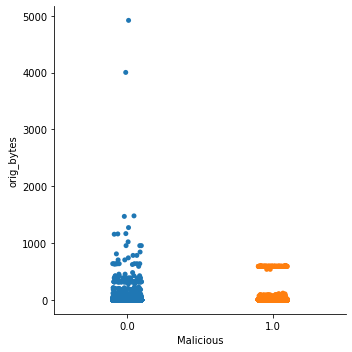

In [33]:
sns.catplot(x="Malicious", y="orig_bytes", data=df)

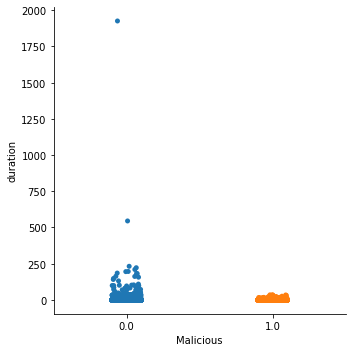

In [34]:
sns.catplot(x="Malicious", y="duration", data=df)

In [35]:
continuous = df.select_dtypes(exclude=['object'])

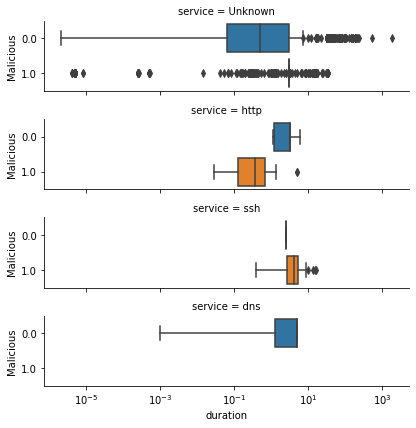

In [36]:
g = sns.catplot(x="duration", y="Malicious", row="service",
                kind="box", orient="h", height=1.5, aspect=4,
                data=df.query("duration > 0"))
g.set(xscale="log")

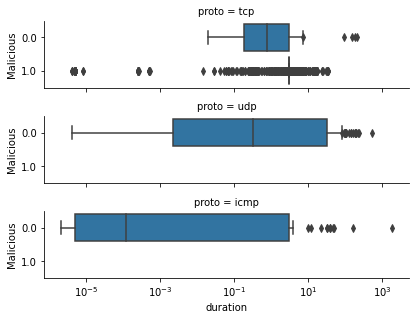

In [37]:
g = sns.catplot(x="duration", y="Malicious", row="proto",
                kind="box", orient="h", height=1.5, aspect=4,
                data=df.query("duration > 0"))
g.set(xscale="log")

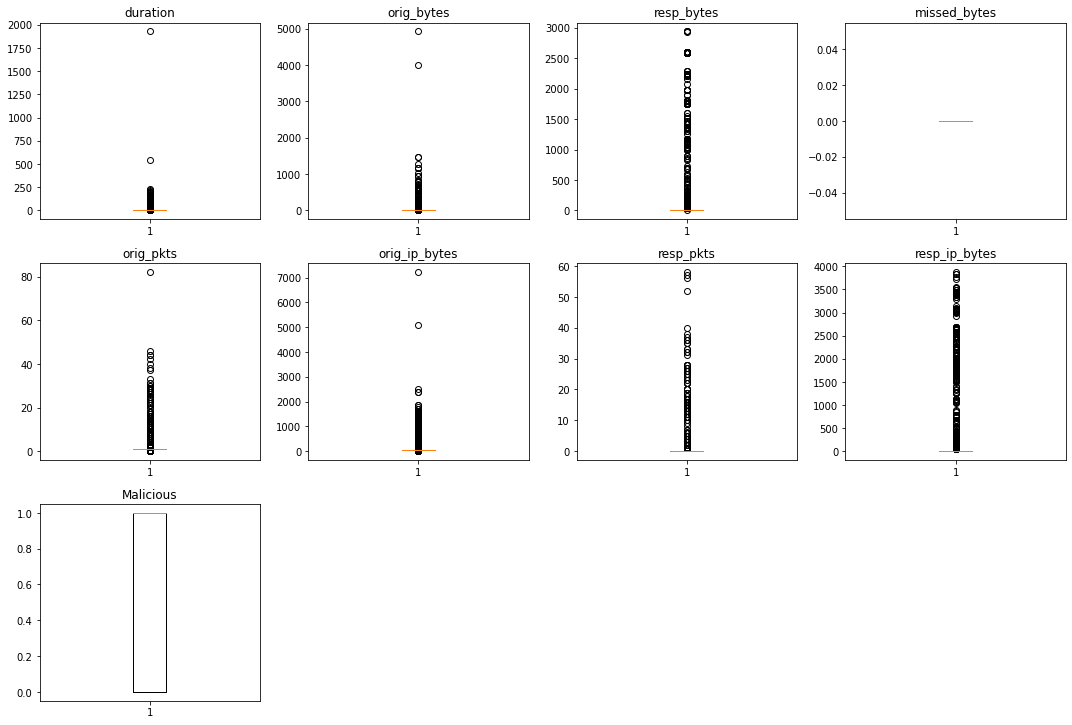

In [38]:
continuous_labels = list(continuous.columns)

i = 1
plt.figure(figsize=(15,30))
for var in continuous_labels: #plotting boxplot for each variable
   plt.subplot(round(len(continuous_labels),0),4,i)
   plt.boxplot(continuous[var],whis=5)
   plt.title(var)
   i+=1
plt.tight_layout()
plt.show()

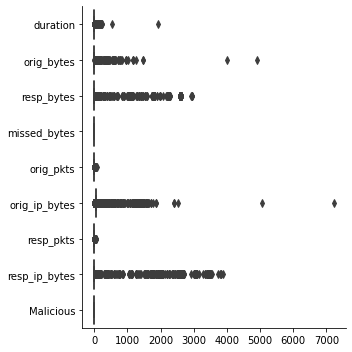

In [39]:
sns.catplot(data=df, orient="h", kind="box")

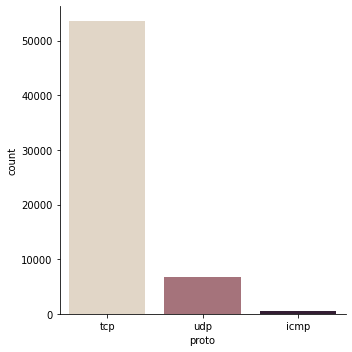

In [40]:
sns.catplot(x="proto", kind="count", palette="ch:.25", data=df)

# Feature Engineering

## One-Hot Encoding

In [41]:

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

#dumie dataset
df_dumie = df

def encode_text_dummy(df_dumie, name):

    dummies = pd.get_dummies(df[name])

    for x in dummies.columns:

        dummy_name = f"{name}-{x}"

        df_dumie[dummy_name] = dummies[x]

    df_dumie.drop(name, axis=1, inplace=True)


#encode_text_dummy(df_dumie,'id.orig_p')

#encode_text_dummy(df_dumie,'id.resp_p')

encode_text_dummy(df_dumie,"proto")

encode_text_dummy(df_dumie,"service")

#encode_text_dummy(df_dumie,"conn_state")

In [42]:
df_dumie

,ts,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,...,resp_ip_bytes,Traffic_Labeled,Malicious,proto-icmp,proto-tcp,proto-udp,service-Unknown,service-dns,service-http,service-ssh
19609,2018-12-20 22:26:30.707983104,43746,8080,0.0,0.0,0.0,S0,0,S,1,...,0,Benign,0.0,0,1,0,1,0,0,0
12201,2018-12-21 11:33:06.178499072,43746,8080,0.0,0.0,0.0,S0,0,S,1,...,0,Benign,0.0,0,1,0,1,0,0,0
9637,2018-05-12 01:08:26.012023040,43763,12902,0.0,0.0,0.0,S0,0,D,1,...,0,Benign,0.0,0,0,1,1,0,0,0
25586,2018-05-13 14:41:52.023395072,43763,37298,0.0,0.0,0.0,S0,0,D,1,...,0,Benign,0.0,0,0,1,1,0,0,0
51390,2018-12-21 09:10:48.430548992,43746,80,0.0,0.0,0.0,S0,0,S,1,...,0,Malicious PartOfAHorizontalPortScan,1.0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33701,2018-12-21 16:24:03.124449024,38370,37215,0.0,0.0,0.0,S0,0,S,1,...,0,Malicious Okiru,1.0,0,1,0,1,0,0,0
33630,2018-12-21 05:03:10.028626944,38370,37215,0.0,0.0,0.0,S0,0,S,1,...,0,Malicious Okiru,1.0,0,1,0,1,0,0,0
11795,2018-12-21 05:10:55.619395072,3,1,0.0,0.0,0.0,OTH,0,Unknown,1,...,0,Benign,0.0,1,0,0,1,0,0,0
48785,2018-05-11 10:16:23.021647872,42133,23,0.0,0.0,0.0,S0,0,S,1,...,0,Malicious PartOfAHorizontalPortScan,1.0,0,1,0,1,0,0,0


In [43]:
df_dumie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60836 entries, 19609 to 53771
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ts               60836 non-null  object 
 1   id.orig_p        60836 non-null  object 
 2   id.resp_p        60836 non-null  object 
 3   duration         60836 non-null  float64
 4   orig_bytes       60836 non-null  float64
 5   resp_bytes       60836 non-null  float64
 6   conn_state       60836 non-null  object 
 7   missed_bytes     60836 non-null  int64  
 8   history          60836 non-null  object 
 9   orig_pkts        60836 non-null  int64  
 10  orig_ip_bytes    60836 non-null  int64  
 11  resp_pkts        60836 non-null  int64  
 12  resp_ip_bytes    60836 non-null  int64  
 13  Traffic_Labeled  60836 non-null  object 
 14  Malicious        60836 non-null  float64
 15  proto-icmp       60836 non-null  uint8  
 16  proto-tcp        60836 non-null  uint8  
 17  proto-ud

### Correlation Matrix

In [44]:
corr = df_dumie.corr()

<AxesSubplot:>

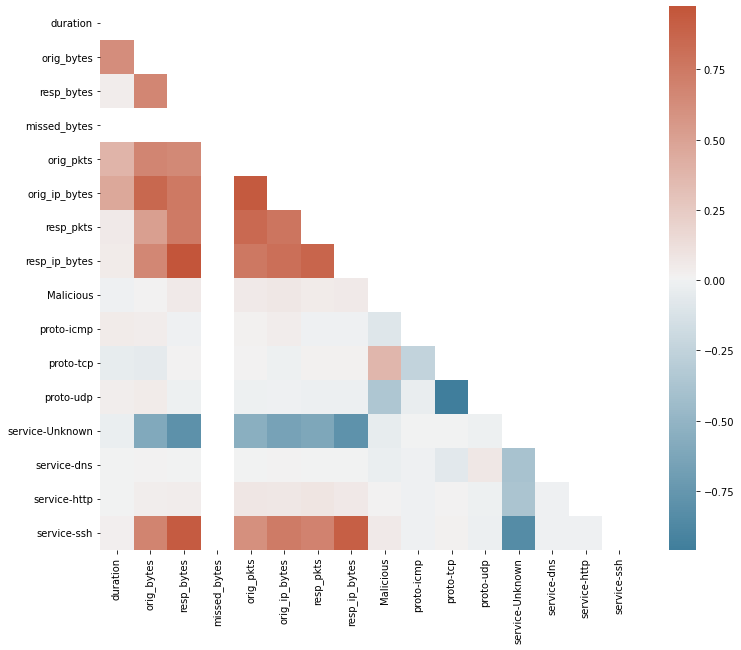

In [45]:
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, mask=mask,annot=False, cmap=cmap)

# Random Forest Classifier

In [46]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

In [47]:
!pip install zat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.5/236.5 kB 5.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.9 MB/s eta 0:00:00


In [48]:
import zat
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from mlens.ensemble import SuperLearner
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
print('zat: {:s}'.format(zat.__version__))
import pandas as pd
print('Pandas: {:s}'.format(pd.__version__))
import numpy as np
print('Numpy: {:s}'.format(np.__version__))
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
print('Scikit Learn Version:', sklearn.__version__)

[MLENS] backend: threading


zat: 0.4.5
Pandas: 1.3.5
Numpy: 1.21.6
Scikit Learn Version: 1.0.2


In [54]:
# Labels are the values we want to predict
y = np.array(df_dumie['Malicious'])

# Remove the labels from the features
# axis 1 refers to the columns
X = df_dumie.drop(['Traffic_Labeled','Malicious'], axis = 1)
X = X.select_dtypes(exclude=['object'])
# Saving feature names for later use
X_list = list(features.columns)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [51]:
# feature scaling

#sc_X = StandardScaler()
#train_features = sc_X.fit_transform(train_features)
#test_features = sc_X.transform(test_features)

In [56]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix  
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

In [65]:
print('--------Applying GaussianNB Classifier ----------')
gnb = GaussianNB()
gnb_fit = gnb.fit(X_train, y_train)  
gnb_prediction = gnb.predict(X_test) 


print('--------Applying KNeighborsClassifier Classifier ----------')
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)

print('--------Applying RandomForestClassifier Classifier ----------')
RF = RandomForestClassifier(max_depth=10, random_state=100)  
RF.fit(X_train, y_train)
RF_prediction = RF.predict(X_test)

print('--------Applying Support vector machine Classifier ----------')
SVM = LinearSVC(loss='hinge', dual=True)
SVM.fit(X_train,y_train)
SVM_prediction = SVM.predict(X_test)

--------Applying GaussianNB Classifier ----------
--------Applying KNeighborsClassifier Classifier ----------
--------Applying RandomForestClassifier Classifier ----------
--------Applying Support vector machine Classifier ----------


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [58]:
print('-------Performance Evaluation----------')
#precision_score, recall_score, f1_score, accuracy_score
results = []
selector = 'LR'
results.append((selector,'','', '',''))
results.append(('Classifier','Accurary','Precision', 'Recall','F1-Score'))
results.append(('KNN ', accuracy_score(y_test, KNN_prediction)*100,
                precision_score(y_test, KNN_prediction)*100,
                recall_score(y_test, KNN_prediction)*100,
                f1_score(y_test, KNN_prediction)*100))
results.append(('RF ', accuracy_score(y_test,  RF_prediction)*100,
                precision_score(y_test,  RF_prediction)*100,
                recall_score(y_test,  RF_prediction)*100,
                f1_score(y_test,  RF_prediction)*100))
results.append(('NB ', accuracy_score(y_test,  gnb_prediction)*100,
                precision_score(y_test,  gnb_prediction)*100,
                recall_score(y_test,  gnb_prediction)*100,
                f1_score(y_test,  gnb_prediction)*100))
results.append(('SVM ', accuracy_score(y_test,  SVM_prediction)*100,
                precision_score(y_test,  SVM_prediction)*100,
                recall_score(y_test,  SVM_prediction)*100,
                f1_score(y_test,  SVM_prediction)*100))


print('type(results): ', type(results))
print('results: ', results)
df_results = pd.DataFrame(results)
print('type(df_results): ', type(df_results))
print('df_results: ', df_results)

-------Performance Evaluation----------
type(results):  <class 'list'>
results:  [('LR', '', '', '', ''), ('Classifier', 'Accurary', 'Precision', 'Recall', 'F1-Score'), ('KNN ', 62.77120315581855, 91.17943548387096, 29.347826086956523, 44.40353460972018), ('RF ', 62.86160420775806, 91.43576826196474, 29.44516547696301, 44.54534298686955), ('NB ', 62.54109138724523, 57.49206941593581, 99.9675535366645, 73.00082928562965), ('SVM ', 62.8698224852071, 57.72479819785996, 99.77287475665152, 73.13592579379235)]
type(df_results):  <class 'pandas.core.frame.DataFrame'>
df_results:              0          1          2          3          4
0          LR                                            
1  Classifier   Accurary  Precision     Recall   F1-Score
2        KNN   62.771203  91.179435  29.347826  44.403535
3         RF   62.861604  91.435768  29.445165  44.545343
4         NB   62.541091  57.492069  99.967554  73.000829
5        SVM   62.869822  57.724798  99.772875  73.135926


In [59]:
print('Confusion Matrix gnb_prediction')
print(confusion_matrix(y_test,gnb_prediction))
print('Confusion Matrix KNN_prediction')
print(confusion_matrix(y_test,KNN_prediction))
print('Confusion Matrix RF_prediction')
print(confusion_matrix(y_test,RF_prediction))
print('Confusion Matrix SVM_prediction')
print(confusion_matrix(y_test,SVM_prediction))

Confusion Matrix gnb_prediction
[[1448 4556]
 [   2 6162]]
Confusion Matrix KNN_prediction
[[5829  175]
 [4355 1809]]
Confusion Matrix RF_prediction
[[5834  170]
 [4349 1815]]
Confusion Matrix SVM_prediction
[[1500 4504]
 [  14 6150]]


In [60]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


SVM Model Accuracy: 0.628698


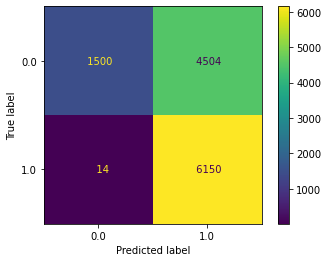

In [61]:
confusionmatrix = plot_confusion_matrix(SVM, X_test, y_test, values_format='5d')
print("SVM Model Accuracy: %f" % SVM.score(X_test, y_test))  
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Naive Bayes Model Accuracy: 0.625411


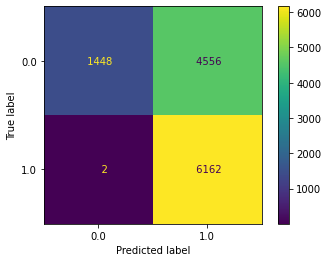

In [62]:
confusionmatrix = plot_confusion_matrix(gnb, X_test, y_test, values_format='5d')
print("Naive Bayes Model Accuracy: %f" % gnb.score(X_test, y_test))  
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 Random Forest Model Accuracy: 0.628616


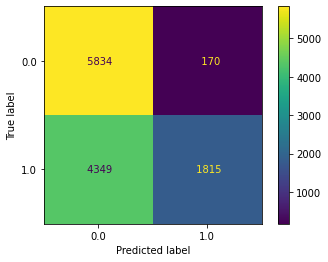

In [63]:
confusionmatrix = plot_confusion_matrix(RF, X_test, y_test, values_format='5d')
print(" Random Forest Model Accuracy: %f" % RF.score(X_test, y_test))  
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


KKN Model Accuracy: 0.627712


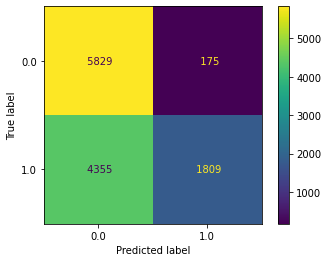

In [64]:
confusionmatrix = plot_confusion_matrix(KNN_model, X_test, y_test, values_format='5d')
print("KKN Model Accuracy: %f" % KNN_model.score(X_test, y_test))  
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


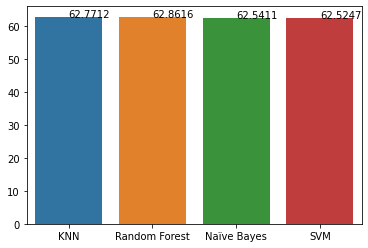

In [68]:
Myscore1 = {'KNN' : 62.7712,'Random Forest': 62.8616, 'Naïve Bayes': 62.5411, 'SVM' : 62.5247}
score1= list(Myscore1.values())
model = list(Myscore1.keys())
sns.barplot(model,score1) 
for index, value in enumerate(score1): 
    plt.text(index,value,str(value)) 
    
plt.show() 

In [66]:
from tabulate import tabulate
Myscore3 = [['KNN', KNN_model.score(X_test, y_test)*100],
            ['Random Forest', RF.score(X_test, y_test)*100], 
            ['Naïve Bayes', gnb.score(X_test, y_test)*100], 
            ['SVM' , SVM.score(X_test, y_test)*100]]

  
#define header names
col_names = ["Model", "Accuracy"]
  
#display table
print(tabulate(Myscore3, headers=col_names))

Model            Accuracy
-------------  ----------
KNN               62.7712
Random Forest     62.8616
Naïve Bayes       62.5411
SVM               62.5247


In [67]:
print('df_results: ', df_results)

df_results:              0          1          2          3          4
0          LR                                            
1  Classifier   Accurary  Precision     Recall   F1-Score
2        KNN   62.771203  91.179435  29.347826  44.403535
3         RF   62.861604  91.435768  29.445165  44.545343
4         NB   62.541091  57.492069  99.967554  73.000829
5        SVM   62.869822  57.724798  99.772875  73.135926


**NOOOOOT**

In [69]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 200, max_depth=20,) 

In [70]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(train_features, train_labels)
 
# performing predictions on the test dataset
y_pred = clf.predict(test_features)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(test_labels, y_pred))


ACCURACY OF THE MODEL:  0.6278763971071664


In [ ]:
from sklearn import datasets, metrics, model_selection, svm
from sklearn.svm import SVC

SVC(random_state=0)
metrics.plot_roc_curve(clf, test_features, test_labels) 

plt.show()

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

In [ ]:
forest_importances = pd.Series(importances, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# XGBoost Classifier & Feature Importance Table

In [ ]:
#Libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
y = df_dumie["Malicious"]
X =  df_dumie.select_dtypes(exclude=['object'])
X = X.drop('Malicious',axis=1)

feature_names = X.columns

In [ ]:
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier

# plot feature importance using built-in function
from xgboost import plot_importance
from matplotlib import pyplot


# fit model no training data
model = XGBClassifier()
model.fit(X,y)

# feature importance
print(model.feature_importances_)

In [ ]:
# plot feature importance
plot_importance(model)
pyplot.show()

In [ ]:
model.fit(train_features, train_labels)

# performing predictions on the test dataset
y_pred = model.predict(test_features)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(test_labels, y_pred))

In [ ]:
from sklearn import datasets, metrics, model_selection, svm
from sklearn.svm import SVC

SVC(random_state=0)
metrics.plot_roc_curve(model, test_features, test_labels) 

plt.show()

In [ ]:
fpr, tpr, _ = metrics.roc_curve(test_labels,  y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Anomaly Exploration

In [ ]:
encode_text_dummy(df_dumie,"history")

In [ ]:
df.columns

In [ ]:
df = df.set_index('ts')

In [ ]:
features = [ 'id.orig_p', 'id.resp_p', 'duration', 'orig_bytes', 'resp_bytes',
       'orig_ip_bytes','resp_ip_bytes', 'proto-icmp',
       'proto-tcp', 'proto-udp', 'service-Unknown', 'service-dns',
       'service-http', 'service-ssh', 'history-C', 'history-D',
       'history-Dd', 'history-R', 'history-S']

In [ ]:
# Use the zat DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data.
#When doing this for real we should explicitly convert before sending to the transformer.
to_matrix = DataFrameToMatrix()
zeek_matrix = to_matrix.fit_transform(df[features], normalize=True)
print(zeek_matrix.shape)
zeek_matrix[:1]

# Silhouette Scoring
"The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters."

In [ ]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 14.0, 7.0

In [ ]:
from sklearn.metrics import silhouette_score

scores = []
clusters = range(2,16)
for K in clusters:
    
    clusterer = KMeans(n_clusters=K)
    cluster_labels = clusterer.fit_predict(zeek_matrix)
    score = silhouette_score(zeek_matrix, cluster_labels)
    scores.append(score)

# Plot it out
pd.DataFrame({'Num Clusters':clusters, 'score':scores}).plot(x='Num Clusters', y='score')

#### For large datasets running an exhaustive search can be time consuming
#### For large datasets you can often get a large K using max score, so pick the 'knee' of the graph as your K
#### K = 4

# Isolation Forest 

#### Isolation Forest works well for high dimensional data.

In [ ]:
# Train/fit and Predict anomalous instances using the Isolation Forest model
odd_clf = IsolationForest(contamination=0.50) # Marking 25% odd
odd_clf.fit(zeek_matrix)

In [ ]:
# Now we create a new dataframe using the prediction from our classifier
odd_df = df[features][odd_clf.predict(zeek_matrix) == -1]
print(df[features].shape)
print(odd_df.shape)
odd_df.head()

In [ ]:
# Now we're going to explore our odd dataframe with help from KMeans and PCA algorithms
odd_matrix = to_matrix.fit_transform(odd_df)

In [ ]:
# Just some simple stuff for this example, KMeans and PCA
# K = 6
kmeans = KMeans(n_clusters=6).fit_predict(odd_matrix) 
pca = PCA(n_components=6).fit_transform(odd_matrix)

# Now we can put our ML results back onto our dataframe!
odd_df['x'] = pca[:, 0] # PCA X Column
odd_df['y'] = pca[:, 1] # PCA Y Column
odd_df['cluster'] = kmeans

print(odd_df.shape)
odd_df.head()

In [ ]:
odd_df= odd_df.join(df['Malicious'])

In [ ]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = 15.0, 6.0

# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


In [ ]:
# Jitter so we can see instances that are projected coincident in 2D
odd_df['jx'] = jitter(odd_df['x'])
odd_df['jy'] = jitter(odd_df['y'])


# Now use dataframe group by cluster
cluster_groups = odd_df.groupby('cluster')

# Plot the Machine Learning results
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown', 6:'pink'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])            

In [ ]:
# Now print out the details for each cluster
pd.set_option('display.width', 6000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group)

# NCC Model

In [ ]:
import keras.models
import tensorflow
from keras.layers import Activation, Dense

In [ ]:
features = zeek_matrix

labels = np.array(df['Malicious'])


In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier

def create_baseline():
# create model
    model = keras.Sequential()
    model.add(Dense(60, input_dim=len(train_features[0]), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
# Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5)
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, features, labels, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))